In [59]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pyarrow as pa
import pyarrow.parquet as pq
import itertools

In [3]:
gender = pd.read_parquet('./data/gender_multilevel.parquet')
ethnicity = pd.read_parquet('./data/ethnicity_multilevel.parquet')
adjusted = pd.read_parquet('./data/adjusted_multilevel.parquet')

In [51]:
gender.rename(columns={
    'beta_Gender_Male_sigma': 'Male',
    'beta_Gender_Female_sigma': 'Female'
}, inplace=True)

ethnicity.rename(columns={
    "beta_Ethnicity_White_sigma": "White",
    "beta_Ethnicity_Asian_sigma": "Asian", 
    "beta_Ethnicity_Hispanic_sigma": "Hispanic",
    "beta_Ethnicity_Mixed_sigma": "Mixed"
}, inplace=True)

In [53]:
column_combinations_gender = list(itertools.combinations(gender[['Male', 'Female']].columns, 2))
column_combinations_ethnicity = list(itertools.combinations(ethnicity[['White', 'Asian', 'Hispanic', 'Mixed']].columns, 2))

In [54]:
def bootstrap(data1, data2):
    B = 10000

    bootstrapped_medians_diffs = np.zeros(B)

    # Perform bootstrapping
    for i in range(B):
        # Generate a bootstrap sample by sampling with replacement
        bootstrap_sample1 = np.random.choice(data1, size=len(data1), replace=True)
        bootstrap_sample2 = np.random.choice(data2, size=len(data2), replace=True)

        # Calculate the mean of the bootstrap sample
        bootstrapped_medians_diffs[i] = np.median(bootstrap_sample1) - np.median(bootstrap_sample2)

    return bootstrapped_medians_diffs

In [55]:
column_combinations_gender

[('Male', 'Female')]

In [58]:
result_dict = {}
for pair in column_combinations_gender:
    first = gender[pair[0]]
    second = gender[pair[1]]
    diff = bootstrap(first, second)
    result_dict[str(pair[0])+' - '+str(pair[1])] = diff
    
for pair in column_combinations_ethnicity:
    first = ethnicity[pair[0]]
    second = ethnicity[pair[1]]
    diff = bootstrap(first, second)
    result_dict[str(pair[0])+' - '+str(pair[1])] = diff

In [60]:
result_dict.keys()

dict_keys(['Male-Female', 'White-Asian', 'White-Hispanic', 'White-Mixed', 'Asian-Hispanic', 'Asian-Mixed', 'Hispanic-Mixed'])

(array([  18.,  181.,  769., 1839., 2798., 2459., 1348.,  487.,   86.,
          15.]),
 array([-0.00182934, -0.00052522,  0.00077891,  0.00208303,  0.00338716,
         0.00469128,  0.00599541,  0.00729953,  0.00860366,  0.00990778,
         0.01121191]),
 <BarContainer object of 10 artists>)

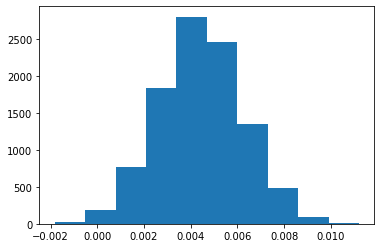

In [13]:
result_df = pd.DataFrame(result_dict)
table = pa.Table.from_pandas(result_df)
pq.write_table(result_df, 'experiment_3_bootstrap.parquet')